## Temperature forecast using Deep Learning Univariable MLP Model

In [1]:
# Common imports
import os
import sys
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

DATA_PATH = "../data/"

reset_graph()

In [2]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
#warnings.filterwarnings("ignore", category=WARNING) 
print(sys.version)
print(tf.__version__)
print(tf.keras.__version__)
print(pd.__version__)

3.5.3 (default, Sep 27 2018, 17:25:39) 
[GCC 6.3.0 20170516]
1.13.1
2.2.4-tf
0.24.2


In [3]:
n_inputs = 1 # input temperature
n_dense_neurons = 150
n_steps = 6 # features or time steps for time series for 6 hrs lag value to forcast
n_outputs = 1 # output temperature
n_layers = 5
n_learning_rate = 0.001
batch_size = 360    # 36 cities, 10 batch of each city
n_epochs = 5000 

# initialize a list to store test results
test_ar = []

In [4]:
# read 'weather_temperature.csv'  dataset as a dataframe
temp_df = pd.read_csv(DATA_PATH + 'weather_temperature.csv', low_memory =  False)
# Convert index column to datetime dtype.
temp_df.datetime = pd.to_datetime(temp_df.datetime, infer_datetime_format = True)
temp_df.set_index('datetime', inplace = True)
print('temp_df ', temp_df.shape)
#print(temp_df.info(verbose = True, null_counts = True))

temp_df_Array = temp_df.values

Columns = temp_df.columns
city_cnt = 36
print(Columns)

temp_df  (44460, 36)
Index(['Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles',
       'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver',
       'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis',
       'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta',
       'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh',
       'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston',
       'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya',
       'Jerusalem'],
      dtype='object')


In [5]:
## split a uni-variate sequence into samples
def split_sequences(ar, n_steps1):
    ts_length = ar.shape[0] - n_steps1 -1
    print('ts_length', ts_length)
    Ts = np.empty([ts_length * city_cnt, (n_steps1 + 1) ])

    print(ar.shape, Ts.shape)
    for i in range(ts_length):
        for k in range(city_cnt):
            Ts[i * city_cnt + k ] = ar.T[k][i: i + n_steps1+1]

    X = Ts[:, :-1]
    y = Ts[:, 1:]    
    return X, y

X, y = split_sequences(temp_df_Array, n_steps)
train_size =  X.shape[0] - batch_size - 48  #test_size * city_cnt
train_size = ((int)(train_size/batch_size)) * batch_size
print(train_size)
test_size = batch_size

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:train_size + test_size]
y_test = y[train_size:train_size + test_size]
print('X_train ', X_train.shape, y_train.shape)
print('X_test ', X_test.shape, y_test.shape)


# All data needs to be scaled to a small range like 0 to 1 for the neural
# network to work well. Create scalers for the inputs and outputs.
# Added 0.1 in min and max value to avoid divide by zero error

X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

X_train_scaled = X_train_scaled.reshape(train_size, n_steps)
y_train_scaled = y_train_scaled.reshape(train_size, n_steps)
X_test_scaled = X_test_scaled.reshape(test_size, n_steps)
y_test_scaled = y_test_scaled.reshape(test_size, n_steps)
print('X_train ', X_train_scaled.shape, y_train_scaled.shape)
print('X_test ', X_test_scaled.shape, y_test_scaled.shape)

ts_length 44453
(44460, 36) (1600308, 7)
1599840
X_train  (1599840, 6) (1599840, 6)
X_test  (360, 6) (360, 6)
X_train  (1599840, 6) (1599840, 6)
X_test  (360, 6) (360, 6)


###### Instead of training the Recurrent Neural Network on the complete sequences of almost 300k observations, we will use the following function to create a batch of shorter sub-sequences picked at random from the training-data.

In [6]:
# Univariate MLP to forecast Temperature

# create model
model = tf.keras.Sequential()

# Adds a densely-connected layer with 64 units to the model:
model.add(tf.layers.Dense(150, activation='relu', input_shape=(n_steps,)))
model.add(tf.layers.BatchNormalization())
model.add(tf.layers.Dropout(0.1))
# Add another:
model.add(tf.layers.Dense(200, activation='relu'))
model.add(tf.layers.BatchNormalization())
model.add(tf.layers.Dropout(0.1))

model.add(tf.layers.Dense(100, activation='relu'))
model.add(tf.layers.BatchNormalization())
model.add(tf.layers.Dropout(0.1))

model.add(tf.layers.Dense(200, activation='relu'))
model.add(tf.layers.BatchNormalization())
model.add(tf.layers.Dropout(0.1))

model.add(tf.layers.Dense(100, activation='relu'))
model.add(tf.layers.BatchNormalization())
model.add(tf.layers.Dropout(0.1))

model.add(tf.layers.Dense(n_steps))

model.compile(loss='mse', optimizer=tf.train.AdamOptimizer(n_learning_rate), metrics=['mse', 'mae', 'mape'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [7]:
strategy = tf.distribute.MirroredStrategy()
config = tf.estimator.RunConfig(train_distribute=strategy, save_checkpoints_steps = 1000)

def train_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_scaled))
    dataset = dataset.shuffle(buffer_size = train_size)
    dataset = dataset.repeat(50)
    dataset = dataset.batch(batch_size, drop_remainder = True)
    return dataset

estimator = tf.keras.estimator.model_to_estimator(model, config=config, model_dir='univar_mlp_model/')
estimator.train(input_fn=train_input_fn, steps=n_epochs)

INFO:tensorflow:Device is available but not used by distribute strategy: /device:CPU:0
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:0
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:1
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_CPU:0
INFO:tensorflow:Configured nccl all-reduce.
INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Using the Keras model provided.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Using config: {'_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9bf4f1c7f0>, '_model_dir': 'univar_mlp_model/', '_train_distribute': <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7f9bf4f1c9b0>, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    met

INFO:tensorflow:global_step/sec: 179.2
INFO:tensorflow:loss = 3.9044313e-05, step = 3400 (0.558 sec)
INFO:tensorflow:global_step/sec: 178.21
INFO:tensorflow:loss = 9.820061e-05, step = 3500 (0.561 sec)
INFO:tensorflow:global_step/sec: 175.612
INFO:tensorflow:loss = 6.983478e-05, step = 3600 (0.569 sec)
INFO:tensorflow:global_step/sec: 179.064
INFO:tensorflow:loss = 6.0728038e-05, step = 3700 (0.559 sec)
INFO:tensorflow:global_step/sec: 178.514
INFO:tensorflow:loss = 0.00012348204, step = 3800 (0.560 sec)
INFO:tensorflow:global_step/sec: 175.781
INFO:tensorflow:loss = 5.5274213e-05, step = 3900 (0.571 sec)
INFO:tensorflow:Saving checkpoints for 4000 into univar_mlp_model/model.ckpt.
INFO:tensorflow:global_step/sec: 63.5227
INFO:tensorflow:loss = 5.3956875e-05, step = 4000 (1.573 sec)
INFO:tensorflow:global_step/sec: 177.312
INFO:tensorflow:loss = 3.6164092e-05, step = 4100 (0.566 sec)
INFO:tensorflow:global_step/sec: 180.699
INFO:tensorflow:loss = 4.5518747e-05, step = 4200 (0.551 sec)


In [8]:
def test_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_scaled))
    dataset = dataset.batch(batch_size, drop_remainder = True)
    print(dataset)
    return dataset

result = estimator.evaluate(input_fn=test_input_fn, steps = 1)

print("loss (test-set):", result)
    
y_pred = estimator.predict(input_fn=test_input_fn)
mape = result['mean_absolute_percentage_error']
mae = result['mean_absolute_error']
rmse = np.sqrt(result['mean_squared_error'])

print(y_pred)
test_ar.append({'label':'DL-MLP', 'mape' : mape, 'mae': mae,'rmse':rmse})    

<DatasetV1Adapter shapes: ((360, 6), (360, 6)), types: (tf.float64, tf.float64)>
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-15T15:55:19Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from univar_mlp_model/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-06-15-15:55:19
INFO:tensorflow:Saving dict for global step 5000: global_step = 5000, loss = 3.8884722e-05, mean_absolute_error = 0.0027220475, mean_absolute_percentage_error = 0.4829912, mean_squared_error = 3.8884722e-05
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: univar_mlp_model/model.ckpt-5000
loss (test-set): {'loss': 3.8884722e-05, 'mean_absolute_error': 0.0027220475, 'mean_absolute_percenta

In [9]:
print(test_ar)

[{'label': 'DL-MLP', 'mape': 0.4829912, 'rmse': 0.0062357616, 'mae': 0.0027220475}]


In [10]:
predict_scaled = list(y_pred)
print(len(predict_scaled))
predict_ar = np.array(predict_scaled)
#print(predict_ar)

<DatasetV1Adapter shapes: ((360, 6), (360, 6)), types: (tf.float64, tf.float64)>
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from univar_mlp_model/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
360


In [11]:
print(predict_ar.shape)
y_pred_scaled = np.empty([predict_ar.shape[0], n_steps])
print(y_pred_scaled.shape)
for i in range(predict_ar.shape[0]):
    predict_val = list(predict_ar[i].values())
    #print(predict_val)
    y_pred_scaled[i] = predict_val[0].reshape(predict_val[0].shape[0])
print(y_pred_scaled.shape)
y_pred_scaled = y_pred_scaled.reshape(predict_ar.shape[0], n_steps, 1)
print(y_pred_scaled.shape)
print(y_test_scaled.shape)

(360,)
(360, 6)
(360, 6)
(360, 6, 1)
(360, 6)


sequence_test  (36, 1, 10, 6)
(360, 6) 360
(360, 6, 1)
(360, 6, 1)
(36, 1, 10, 6)


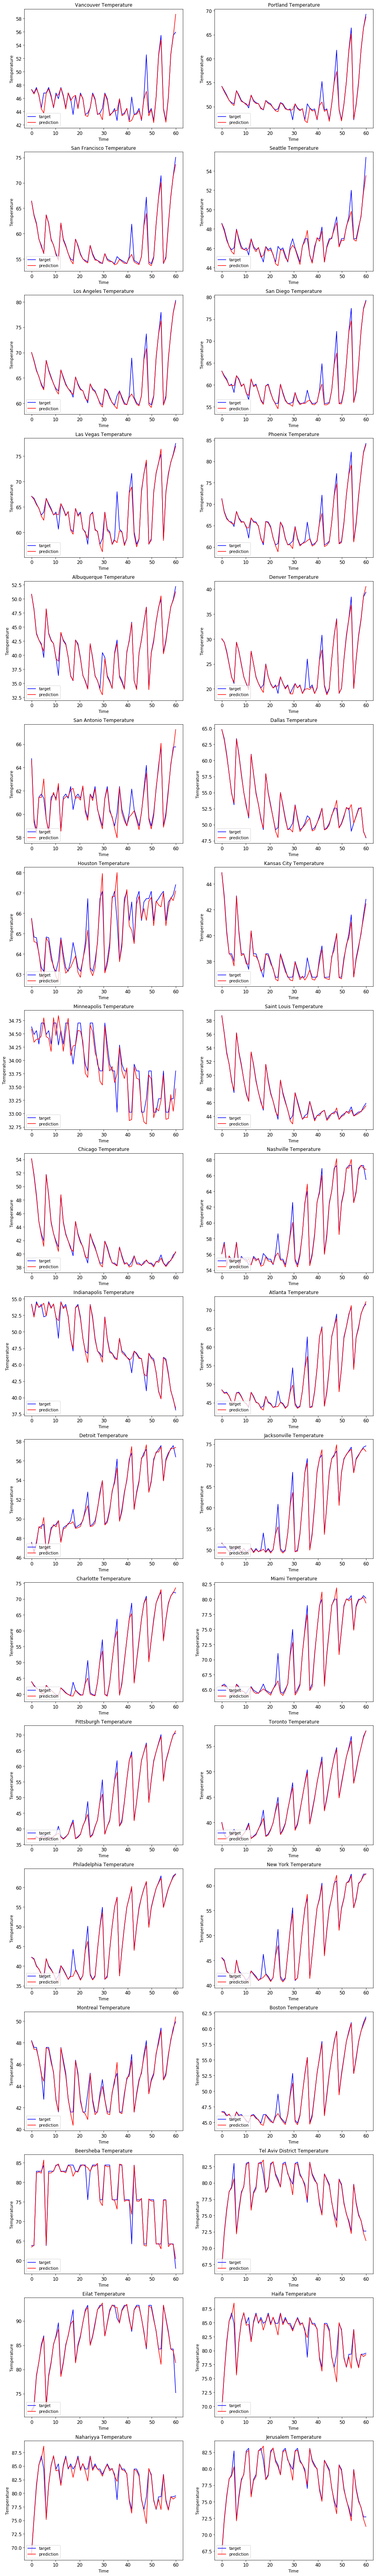

In [12]:
iterations = (int)(batch_size / city_cnt)
sequence_pred = np.empty([city_cnt, n_inputs, iterations, n_steps])
sequence_test = np.empty([city_cnt, n_inputs, iterations, n_steps])
print('sequence_test ', sequence_test.shape)

def plot_predictions(sequence_test, sequence_pred):
    
    plt.rcParams["figure.figsize"] = [16, 120]
    f, ax = plt.subplots(18, 2, sharex = False, sharey = False)
    
       
    for i in range(36):
        p_sequence = sequence_pred[i].flatten()
        t_sequence = sequence_test[i].flatten()
        
        t_instance = np.linspace(0, len(t_sequence), len(t_sequence)).reshape(-1, 1)
        row = (int)(i / 2)
        col = (int)(i % 2)

        axes = ax[row][col]
        str = "%s Temperature" % (Columns[i])
        
        axes.set_title(str, fontsize=12)

        axes.plot(t_instance, t_sequence, "b", markersize=10, label="target")
        axes.plot(t_instance, p_sequence, "r", markersize=10, label="prediction")

        axes.legend(loc="lower left")
        axes.set_xlabel("Time", fontsize=11)
        axes.set_ylabel("Temperature", fontsize=11)
    plt.show()
print(y_test_scaled.shape, batch_size)
y_test_unscaled = y_scaler.inverse_transform(y_test_scaled.reshape(batch_size, n_steps)).reshape(batch_size, n_steps, 1)
y_pred_unscaled = y_scaler.inverse_transform(y_pred_scaled.reshape(batch_size, n_steps)).reshape(batch_size, n_steps, 1)

print(y_pred_unscaled.shape)
print(y_test_unscaled.shape)

for s in range(batch_size):
    city = (int)(s%city_cnt)
    index = (int)(s/city_cnt)
    for col in range(n_inputs):
        sequence_test[city][col][index] = y_test_unscaled[s].T[col]
        sequence_pred[city][col][index] = y_pred_unscaled[s].T[col]

print(sequence_test.shape)
plot_predictions(sequence_test, sequence_pred)